In [36]:
from fastcore.all import *
from transformers import AutoModel
from fastprogress import progress_bar
import numpy as np, polars as pl, umap, hdbscan, plotly.express as px

# Clustering

## Dataset

In [2]:
df_raw = pl.read_csv('hf://datasets/somosnlp/RecetasDeLaAbuela/main.csv', infer_schema_length=10000)
df_raw.shape

(20236, 14)

In [3]:
print(df_raw.columns)

['Id', 'Nombre', 'URL', 'Ingredientes', 'Pasos', 'Pais', 'Duracion', 'Categoria', 'Contexto', 'Valoracion y Votos', 'Comensales', 'Tiempo', 'Dificultad', 'Valor nutricional']


In [4]:
df_raw.head(2)

Id,Nombre,URL,Ingredientes,Pasos,Pais,Duracion,Categoria,Contexto,Valoracion y Votos,Comensales,Tiempo,Dificultad,Valor nutricional
i64,str,str,str,str,str,str,str,str,str,str,str,str,str
1,"""Tacos Dorados de Papa""","""https://www.mexicoenmicocina.c…","""½ taza de cilantro finamente p…","""Pon las papas enteras en una o…","""MEX""","""01:00""","""vegetarianos""",null,null,"""6""",null,null,"""Alto en calorías, Alto en gras…"
2,"""Ensalada de Chayotes""","""https://www.mexicoenmicocina.c…","""½ cucharadita sal, ¼ cucharadi…","""Coloca los chayotes en una cac…","""MEX""","""00:25""","""vegetarianos""",null,null,"""4""",null,null,"""Bajo en calorías, Sin grasa, A…"


In [5]:
df = (
    df_raw
    .rename(lambda s: s.lower().replace(' ','_'))
    .select(
        'nombre', 'pais', 'categoria', 'pasos',
        (
            'Receta: ' + pl.col.nombre
            + '\nPais: ' + pl.col.pais
            + '\nCategoria: ' + pl.col.categoria
            + '\nNutricion: ' + pl.col.valor_nutricional
            + '\n\nIngredientes:\n' + pl.col.ingredientes
            # Para efectos de la demo no vamos a considerar los "pasos" para no hacer tan largo el texto
            # + '\n\nPasos:\n' + pl.col.pasos 
        ).alias('text')
    )
    .drop_nulls()
)
print(df.shape)
df.head(3)

(10758, 5)


nombre,pais,categoria,pasos,text
str,str,str,str,str
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …"
"""Ensalada de Chayotes""","""MEX""","""vegetarianos""","""Coloca los chayotes en una cac…","""Receta: Ensalada de Chayotes P…"
"""Huevos a la Mexicana""","""MEX""","""vegetarianos""","""Calienta el aceite en una sart…","""Receta: Huevos a la Mexicana P…"


In [6]:
print('\n==============\n'.join(df['text'].sample(3)))

Receta: tocinillo de naranja con thermomix
Pais: ESP
Categoria: ['Recetas españolas', 'Recetas andaluzas']
Nutricion: Alto en azúcar, Alto en grasas, Sin colesterol

Ingredientes:
['almibar', '2 cub de zumo de naranja', '4 cub de azucar', 'tocino', '8 yemas', 'un huevo']
Receta: lenguado menier
Pais: ESP
Categoria: ['Receta sin azúcar']
Nutricion: Alto en grasas, Alto en calorías, Bueno en fibra

Ingredientes:
['4 filetes de Lenguado', '1 vaso de Leche', '50 gramos de Harina', '75 gramos de Mantequilla                                                                    (⅓ taza)', '1 cucharada sopera de Perejil picado', '1 unidad de Limón (zumo)', '1 pizca de Sal', '1 chorro de Aceite']
Receta: causa rellena con atun
Pais: PER
Categoria: ['Recetas peruanas']
Nutricion: Alto en grasas, Alto en calorías, Sin sodio

Ingredientes:
['1 taza de Mayonesa', '1 Cebolla', '3 Huevos cocidos', '10 Aceitunas negras', '¼ libra de Queso blanco', '1 Aguacate', '1 puñado de Perejil fresco', '1 lata de At

In [25]:
df['text'].str.len_chars().describe()

statistic,value
str,f64
"""count""",10758.0
"""null_count""",0.0
"""mean""",416.503718
"""std""",124.709025
"""min""",144.0
"""25%""",330.0
"""50%""",399.0
"""75%""",481.0
"""max""",1390.0


## Embeddings

In [8]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v3', trust_remote_code=True).cuda()

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

In [37]:
embs = []
for b in progress_bar(L(chunked(df['text'], 256))):
    embs.append(model.encode(b, truncate_dim=128, task='separation'))
    
embs = np.concatenate(embs)
np.save('06_embs.npy', embs)
embs.shape

(10758, 128)

In [42]:
embs = np.load('06_embs.npy')
embs.shape

(10758, 128)

In [44]:
%%time
reducer = umap.UMAP(n_components=2, metric='cosine').fit(embs)
reducer.embedding_.shape

CPU times: user 26 s, sys: 1.26 s, total: 27.2 s
Wall time: 11.7 s


(10758, 2)

In [47]:
hdb = hdbscan.HDBSCAN(min_cluster_size=100).fit(reducer.embedding_)
f'# clusters: {hdb.labels_.max()}'

/home/renato/github/pucp_bootcamp_202401/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renato/github/pucp_bootcamp_202401/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


'# clusters: 10'

In [48]:
df_clusters = df.with_columns(
    x=reducer.embedding_[:,0], y=reducer.embedding_[:,1],
    cluster=pl.Series(hdb.labels_).cast(str),
)
df_clusters.head(2)

nombre,pais,categoria,pasos,text,x,y,cluster
str,str,str,str,str,f32,f32,str
"""Tacos Dorados de Papa""","""MEX""","""vegetarianos""","""Pon las papas enteras en una o…","""Receta: Tacos Dorados de Papa …",9.074079,13.030457,"""7"""
"""Ensalada de Chayotes""","""MEX""","""vegetarianos""","""Coloca los chayotes en una cac…","""Receta: Ensalada de Chayotes P…",9.889827,12.606191,"""7"""


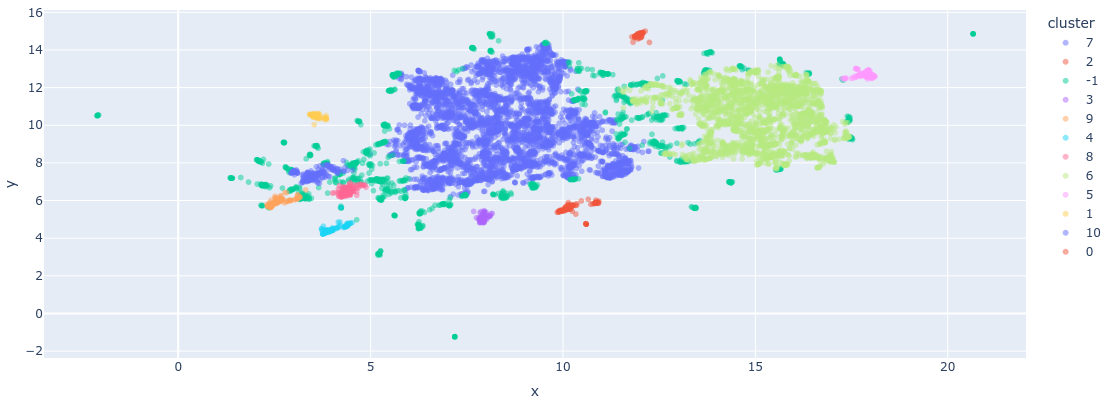

In [51]:
fig = px.scatter(
    df_clusters, x='x', y='y', color='cluster', hover_data=['nombre','pais','categoria','cluster'],
    opacity=0.5, width=1000, height=400,
)
fig.update_layout(margin=dict(l=0, r=0, t=10, b=0))
fig.show()